In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import math
import time

### Import tracking data

In [2]:
df = pd.read_csv('/Users/vivekhsridhar/Library/Mobile Documents/com~apple~CloudDocs/Documents/Code/Python/SpatialRegistration/io/tracksp1d1.csv')
df['x'] = df['bb_left'] + df['bb_width']/2
df['y'] = df['bb_top'] + df['bb_height']/2
df['idx'] = df['track_id']

df = df.loc[:,['frame', 'x', 'y', 'idx']]
df.head()

,frame,x,y,idx
0,0,3231.399,58.680,1
1,0,1596.498,174.696,2
2,0,3602.919,276.867,3
3,0,2578.536,318.834,4
4,0,1220.571,437.763,5


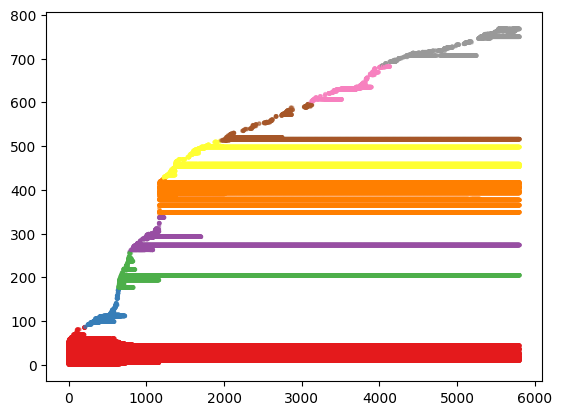

In [3]:
plt.scatter(df['frame'], df['idx'], c=df['idx'], cmap='Set1', s=5, alpha=0.4)

### Apply homography

In [4]:
# Function to compute homography and extract translation, rotation, and scale
def compute_translation_rotation_scale(H):
    # Extract translation in x and y
    t_x = H[0, 2]
    t_y = H[1, 2]
    translation_xy = np.sqrt(t_x**2 + t_y**2)
    
    # Extract rotation angle from the top-left 2x2 submatrix
    r_11, r_21 = H[0, 0], H[1, 0]
    rotation_angle = math.atan2(r_21, r_11) * (180 / np.pi)  # convert to degrees
    
    # Extract scale factor from H[2, 2]
    scale_factor = 1 / H[2, 2]  # Inverse of the bottom-right value
    
    return translation_xy, rotation_angle, scale_factor

def identify_anchor_frames(df, thresholds):
    start_time = time.time()
    
    # Initialize variables
    anchor_frames = [0]  # Start with frame 0 as the first anchor frame
    
    # Get unique frames, sorted to process in order
    unique_frames = sorted(df['frame'].unique())
    
    # Set initial anchor frame
    anchor_frame = 0
    
    for frame in unique_frames:
        if frame == anchor_frame:
            continue
        
        # Get points in the current frame and anchor frame
        current_points = df[df['frame'] == frame][['idx', 'x', 'y']]
        anchor_points = df[df['frame'] == anchor_frame][['idx', 'x', 'y']]
        
        # Merge points on 'idx' to get corresponding points
        merged_points = pd.merge(current_points, anchor_points, on='idx', suffixes=('_current', '_anchor'))
        
        if len(merged_points) < 4:
            print(f"Not enough matching points for homography between frame {anchor_frame} and frame {frame}.")
            continue
        
        src_pts = merged_points[['x_anchor', 'y_anchor']].values
        dst_pts = merged_points[['x_current', 'y_current']].values
        
        # Apply RANSAC to find homography
        try:
            H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC)
        except cv2.error as e:
            print(f"Homography calculation failed between frame {anchor_frame} and frame {frame}: {e}")
            continue
        
        # Calculate translation, rotation, and scale
        translation_xy, rotation_angle, scale_factor = compute_translation_rotation_scale(H)
        
        # Determine if the thresholds are exceeded
        threshold_exceeded = (translation_xy > thresholds['T_translation']) or \
                             (abs(rotation_angle) > thresholds['T_rotation']) or \
                             (abs(scale_factor - 1) > thresholds['T_scale'])
                             
        if threshold_exceeded:
            anchor_frames.append(frame)
            anchor_frame = frame  # Update the anchor frame
    
    end_time = time.time()
    print('Initial identification of anchors takes ', end_time - start_time)
    
    return anchor_frames

In [5]:
def find_best_anchor_for_each_frame(df, anchor_frames, thresholds):
    start_time = time.time()
    
    # Create a new column to store the best anchor frame for each frame
    df['best_anchor_frame'] = np.nan
    
    # Loop through all frames
    unique_frames = sorted(df['frame'].unique())
    
    for frame in unique_frames:
        # If the frame itself is an anchor, set itself as the anchor
        if frame in anchor_frames:
            df.loc[df['frame'] == frame, 'best_anchor_frame'] = frame
            continue
        
        # Compare against all preceding anchor frames
        best_anchor = None
        best_inliers = 0  # To keep track of the best match based on inliers
        
        for anchor_frame in anchor_frames:
            # Get points in the current frame and the candidate anchor frame
            current_points = df[df['frame'] == frame][['idx', 'x', 'y']]
            anchor_points = df[df['frame'] == anchor_frame][['idx', 'x', 'y']]
            
            # Merge points on 'idx' to get corresponding points
            merged_points = pd.merge(current_points, anchor_points, on='idx', suffixes=('_current', '_anchor'))
            
            if len(merged_points) < 4:
                continue  # Skip if not enough points to calculate homography
            
            src_pts = merged_points[['x_anchor', 'y_anchor']].values
            dst_pts = merged_points[['x_current', 'y_current']].values
            
            # Apply RANSAC to find homography
            try:
                H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC)
                inliers_count = np.sum(mask)  # Number of inliers
            except cv2.error as e:
                continue  # Skip if homography calculation failed
            
            # If this anchor frame gives more inliers, choose it as the best anchor
            if inliers_count > best_inliers:
                best_anchor = anchor_frame
                best_inliers = inliers_count
        
        # Assign the best anchor for the current frame
        if best_anchor is not None:
            df.loc[df['frame'] == frame, 'best_anchor_frame'] = best_anchor
    
    end_time = time.time()
    print('Finding the best anchors takes ', end_time - start_time)
    
    return df

In [6]:
def apply_homography_to_best_anchor(df):
    start_time = time.time()
    
    homography_matrices = {}  # Dictionary to store homography matrices
    
    # Initialize with the identity matrix for frame 0
    identity_matrix = np.eye(3)
    homography_matrices[0] = identity_matrix  # Frame 0 is its own anchor
    
    df['transformed_x'] = np.nan
    df['transformed_y'] = np.nan
    
    unique_frames = sorted(df['frame'].unique())
    
    for frame in unique_frames:
        best_anchor_frame = df.loc[df['frame'] == frame, 'best_anchor_frame'].values[0]
        
        if frame == best_anchor_frame:
            # If the frame is its own anchor, copy the coordinates directly
            df.loc[df['frame'] == frame, 'transformed_x'] = df['x']
            df.loc[df['frame'] == frame, 'transformed_y'] = df['y']
            
            # Store identity matrix for this frame in the dictionary
            homography_matrices[frame] = identity_matrix
            continue
        
        # Get points in the current frame and its best anchor frame
        current_points = df[df['frame'] == frame][['idx', 'x', 'y']]
        anchor_points = df[df['frame'] == best_anchor_frame][['idx', 'x', 'y']]
        
        # Merge points on 'idx' to get corresponding points
        merged_points = pd.merge(current_points, anchor_points, on='idx', suffixes=('_current', '_anchor'))
        
        if len(merged_points) < 4:
            print(f"Not enough matching points for homography between frame {best_anchor_frame} and frame {frame}.")
            continue
        
        src_pts = merged_points[['x_anchor', 'y_anchor']].values
        dst_pts = merged_points[['x_current', 'y_current']].values
        
        # Apply RANSAC to find homography
        try:
            H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC)
            homography_matrices[frame] = H  # Store the homography matrix for this frame
        except cv2.error as e:
            print(f"Homography calculation failed between frame {best_anchor_frame} and frame {frame}: {e}")
            continue
        
        # Transform the points using the homography matrix
        transformed_pts = cv2.perspectiveTransform(np.array([current_points[['x', 'y']].values], dtype=np.float32), H)[0]
        
        # Update DataFrame with transformed coordinates
        df.loc[df['frame'] == frame, 'transformed_x'] = transformed_pts[:, 0]
        df.loc[df['frame'] == frame, 'transformed_y'] = transformed_pts[:, 1]
    
    end_time = time.time()
    print('Applying homography to the best anchors takes ', end_time - start_time)
    
    return df, homography_matrices

In [7]:
# Thresholds for translation, rotation, and scale
thresholds = {
    'T_translation': 50,  # e.g., 50 pixels
    'T_rotation': 10,     # e.g., 10 degrees
    'T_scale': 0.1        # e.g., 10% change
}

In [8]:
# Step 1: Identify anchor frames
anchor_frames = identify_anchor_frames(df, thresholds)

# Step 2: Find the best anchor for each frame
df = find_best_anchor_for_each_frame(df, anchor_frames, thresholds)

# Step 3: Apply homography using the best anchor for each frame
df, homography_matrices = apply_homography_to_best_anchor(df)

df.to_csv('/Users/vivekhsridhar/Library/Mobile Documents/com~apple~CloudDocs/Documents/Code/Python/SpatialRegistration/io/anchoredp1d1.csv', index=False, mode='w')

Initial identification of anchors takes  29.918789863586426
Finding the best anchors takes  1959.1854379177094
Applying homography to the best anchors takes  23.25964903831482


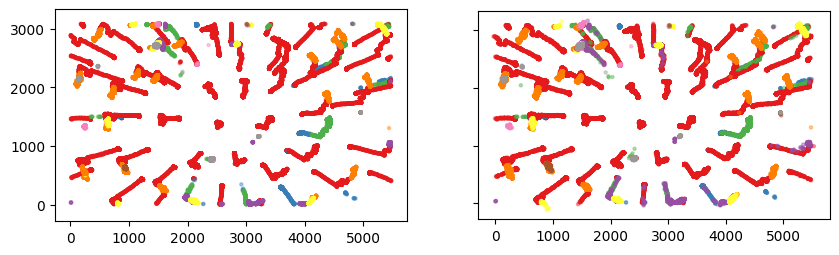

In [9]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(10,5), sharey=True)

ax1.scatter(df['x'], df['y'], c=df['idx'], cmap='Set1', s=5, alpha=0.4)
ax1.set_aspect('equal')

ax2.scatter(df['transformed_x'], df['transformed_y'], c=df['idx'], cmap='Set1', s=5, alpha=0.4)
ax2.set_aspect('equal')

plt.show()

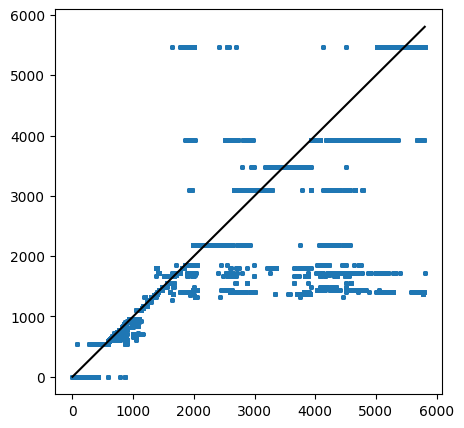

In [10]:
fig,ax = plt.subplots(1,1, figsize=(5,5))

ax.scatter(df['frame'], df['best_anchor_frame'], s=5)
ax.plot(np.linspace(0,df['frame'].max()), np.linspace(0,df['frame'].max()), c='black')

plt.show()

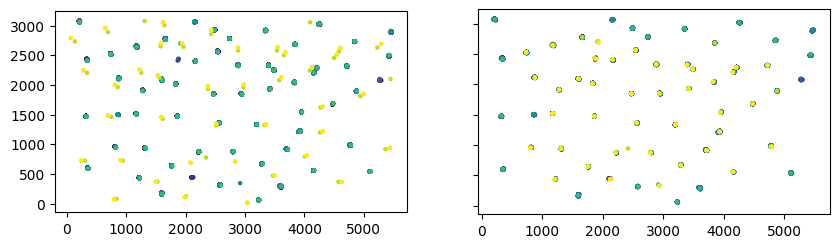

In [11]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(10,5), sharey=True)

anchor = 0
ax1.scatter(df.loc[df['best_anchor_frame'] == anchor, 'x'], df.loc[df['best_anchor_frame'] == anchor, 'y'], c=df.loc[df['best_anchor_frame'] == anchor, 'frame'], s=5)
ax1.set_aspect('equal')

ax2.scatter(df.loc[df['best_anchor_frame'] == anchor, 'transformed_x'], df.loc[df['best_anchor_frame'] == anchor, 'transformed_y'], c=df.loc[df['best_anchor_frame'] == anchor, 'frame'], s=5)
ax2.set_aspect('equal')

plt.show()